## Plot waveforms, azimuths, emergence, temperature, etc. of families

### Import libraries

In [1]:
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import os
import math
import datetime
from matplotlib import gridspec
from scipy.fft import fft, fftfreq
from PIL import Image
import glob

# Import functions
import sys
fxndir = '../functions/'
sys.path.insert(0,fxndir)
from moon2data import *
from moonquake_temperatures import *

### Load catalogs of repeating moonquakes

In [2]:
# Catalog with information by geophone
mqdir = '../catalogs/final_catalogs/isolated_vs_repeating/'
repeating_cat1 = pd.read_csv(mqdir + 'A17_repeating_catalog_HQ_final.csv')
repeating_cat1.drop(list(repeating_cat1.filter(regex='Unnamed|index')), axis=1, inplace=True)

# Catalog with information averaged per event
repeating_cat2 = pd.read_csv(mqdir + 'A17_repeating_catalog_HQ_avg_event_stats.csv')
repeating_cat2.drop(list(repeating_cat2.filter(regex='Unnamed|index')), axis=1, inplace=True)
evid_refs = np.unique(repeating_cat2.evid_ref.tolist())

### Count number of events per family

In [3]:
numevts = []
for evid in evid_refs:
    rows = repeating_cat2.loc[repeating_cat2.evid_ref == evid]
    numevts.append(len(rows))
    
df = pd.DataFrame(data = {'evid_ref':evid_refs, 'numevts':numevts})
df = df.sort_values(by=['numevts'],ascending=False,ignore_index=True)
evid_refs = np.array(df.evid_ref.tolist())

### Inputs to obtain waveforms

In [4]:
parentdir = '/data/ytamama/Apollo17/LSPE_data/sac_volts_ds/'
minfreq = 3
maxfreq = ''
befwin = 10
aftwin = 30

### Load temperature data

In [5]:
tempdir = '../catalogs/temperature/'
temp_df, int_df = load_temp_cats(tempdir)

# Start and end time of one cycle
starttime_str = int_df.iloc[0]['start times']
starttime = datetime.strptime(int_df.iloc[0]['start times'],'%Y-%m-%d %H:%M:%S')
endtime_str = int_df.iloc[2]['end times']
endtime = datetime.strptime(int_df.iloc[2]['end times'],'%Y-%m-%d %H:%M:%S')

# Times and temperatures 
temp_df_day = temp_df.loc[(temp_df.Time_YMD >= starttime_str) & (temp_df.Time_YMD <= endtime_str)]
times_day = np.array(temp_df_day.Time_s.tolist())/(3600*24)
rock_temps_day = np.array(temp_df_day.T_rock_K.tolist())
reg_temps_day = np.array(temp_df_day.T_reg_K.tolist())

### Test one family

#### Load catalog with family

In [6]:
evid_ref = '761226-15-M1'
#evid_ref = '761029-04-M3'
#evid_ref = '761227-18-M6'
rows1 = repeating_cat1.loc[repeating_cat1.evid_ref == evid_ref]
rows2 = repeating_cat2.loc[repeating_cat2.evid_ref == evid_ref]
evids_family = np.unique(rows2.evid.tolist())
num_evts = len(evids_family)

#### Stack waveforms of family

In [7]:
first1 = 1
first2 = 1
first3 = 1
first4 = 1

# Iterate through events
for r in np.arange(0,len(rows1)):
    
    # Arrival time
    row1 = rows1.iloc[r]
    geonum = row1.geophone
    evid = row1.evid
    row2 = rows2.loc[rows2.evid == evid].iloc[0]
    arrtime_avg = datetime.strptime(row2.avg_picktime_SNR, '%Y-%m-%d %H:%M:%S.%f')
    st = moon2sac(arrtime_avg,geonum,befwin,aftwin,minfreq,maxfreq,parentdir)
    
    # Geophone 1
    if geonum == 1:
        if (st != '') & (first1 == 1):
            evtst1 = st.copy()
            first1 = 0
        elif (st != '') & (first1 == 0):
            evtst1 += st
            
    # Geophone 2
    elif geonum == 2:
        if (st != '') & (first2 == 1):
            evtst2 = st.copy()
            first2 = 0
        elif (st != '') & (first2 == 0):
            evtst2 += st
            
    # Geophone 3
    elif geonum == 3:
        if (st != '') & (first3 == 1):
            evtst3 = st.copy()
            first3 = 0
        elif (st != '') & (first3 == 0):
            evtst3 += st
            
    # Geophone 4
    elif geonum == 4:
        if (st != '') & (first4 == 1):
            evtst4 = st.copy()
            first4 = 0
        elif (st != '') & (first4 == 0):
            evtst4 += st
    
# Stack
# Geophone 1
st_stack1 = evtst1.copy()
st_stack1.stack(npts_tol=2)
# Geophone 2
st_stack2 = evtst2.copy()
st_stack2.stack(npts_tol=2)
# Geophone 3
st_stack3 = evtst3.copy()
st_stack3.stack(npts_tol=2)
# Geophone 4
st_stack4 = evtst4.copy()
st_stack4.stack(npts_tol=2)

# Geophone 1
trtimes1 = st_stack1.traces[0].times() - befwin
trdata1 = st_stack1.traces[0].data

# Geophone 2
trtimes2 = st_stack2.traces[0].times() - befwin
trdata2 = st_stack2.traces[0].data

# Geophone 3
trtimes3 = st_stack3.traces[0].times() - befwin
trdata3 = st_stack3.traces[0].data

# Geophone 4
trtimes4 = st_stack4.traces[0].times() - befwin
trdata4 = st_stack4.traces[0].data

# Normalize relative to Geophone 1
trdata1_norm = trdata1 / np.max(np.abs(trdata1))
trdata2_norm = trdata2 / np.max(np.abs(trdata1))
trdata3_norm = trdata3 / np.max(np.abs(trdata1))
trdata4_norm = trdata4 / np.max(np.abs(trdata1))

#### Obtain event properties

In [8]:
# Obtain waveform characteristics of family
int_days = np.array(rows2.avg_interval_day.tolist())
pgvs = np.array(rows2.avg_PGV.tolist())
durations = np.array(rows1.duration_s.tolist())
emergences = np.array(rows2.avg_emergence_s.tolist())

# Obtain azimuths of family
thetas_lag = np.array(rows2.theta_mean_lag_deg.tolist())
sds_lag = np.array(rows2.theta_sd_lag_deg.tolist())
thetas_snr = np.array(rows2.theta_mean_snr_deg.tolist())
sds_snr = np.array(rows2.theta_sd_snr_deg.tolist())

# Bin azimuths from lag
theta_mean_radii_lag = (thetas_lag * np.pi) / 180
counts_lag, histbins_lag = np.histogram(theta_mean_radii_lag)
histbins_lag = histbins_lag[:-1]

# Bin azimuths from SNR pick
theta_mean_radii_snr = (thetas_snr * np.pi) / 180
counts_snr, histbins_snr = np.histogram(theta_mean_radii_snr)
histbins_snr = histbins_snr[:-1]

#### Stack frequency spectra

In [9]:
T = 1/117.6
first1 = 1
first2 = 1
first3 = 1
first4 = 1
num1 = 0
num2 = 0
num3 = 0
num4 = 0

# Iterate through events
for r in np.arange(0,len(rows1)):
    
    # Obtain trace
    row1 = rows1.iloc[r]
    arrtime = datetime.strptime(row1.picktime_SNR, '%Y-%m-%d %H:%M:%S.%f')
    geonum = row1.geophone
    st = moon2sac(arrtime,geonum,befwin,aftwin,minfreq,maxfreq,parentdir)
    trdata = st.traces[0].data
    
    # Normalize each FFT with respect to # samples
    N = len(trdata)
    trdata_fft_real = np.abs(fft(trdata).real[0:N//2]) / N
    
    # Which geophone?
    if geonum == 1:
        if first1 == 1:
            trdata1_fft_real = trdata_fft_real.copy()
            first1 = 0
            trdata1 = trdata.copy()
        else:
            trdata1_fft_real += trdata_fft_real.copy()
        num1 += 1
    elif geonum == 2:
        if first2 == 1:
            trdata2_fft_real = trdata_fft_real.copy()
            first2 = 0
            trdata2 = trdata.copy()
        else:
            trdata2_fft_real += trdata_fft_real.copy()
        num2 += 1
    elif geonum == 3:
        if first3 == 1:
            trdata3_fft_real = trdata_fft_real.copy()
            first3 = 0
            trdata3 = trdata.copy()
        else:
            trdata3_fft_real += trdata_fft_real.copy()
        num3 += 1
    elif geonum == 4: 
        if first4 == 1:
            trdata4_fft_real = trdata_fft_real.copy()
            first4 = 0
            trdata4 = trdata.copy()
        else:
            trdata4_fft_real += trdata_fft_real.copy()
        num4 += 1

        
# Frequencies
# Geophone 1
N = len(trdata1)
T = 1/117.6
freqs1 = fftfreq(N, T)[:N//2]

# Geophone 2
N = len(trdata2)
freqs2 = fftfreq(N, T)[:N//2]

# Geophone 3
N = len(trdata3)
freqs3 = fftfreq(N, T)[:N//2]

# Geophone 4
N = len(trdata4)
freqs4 = fftfreq(N, T)[:N//2]

#### Plot

Text(0.5, 0.95, '761226-15-M1 (N = 362)')

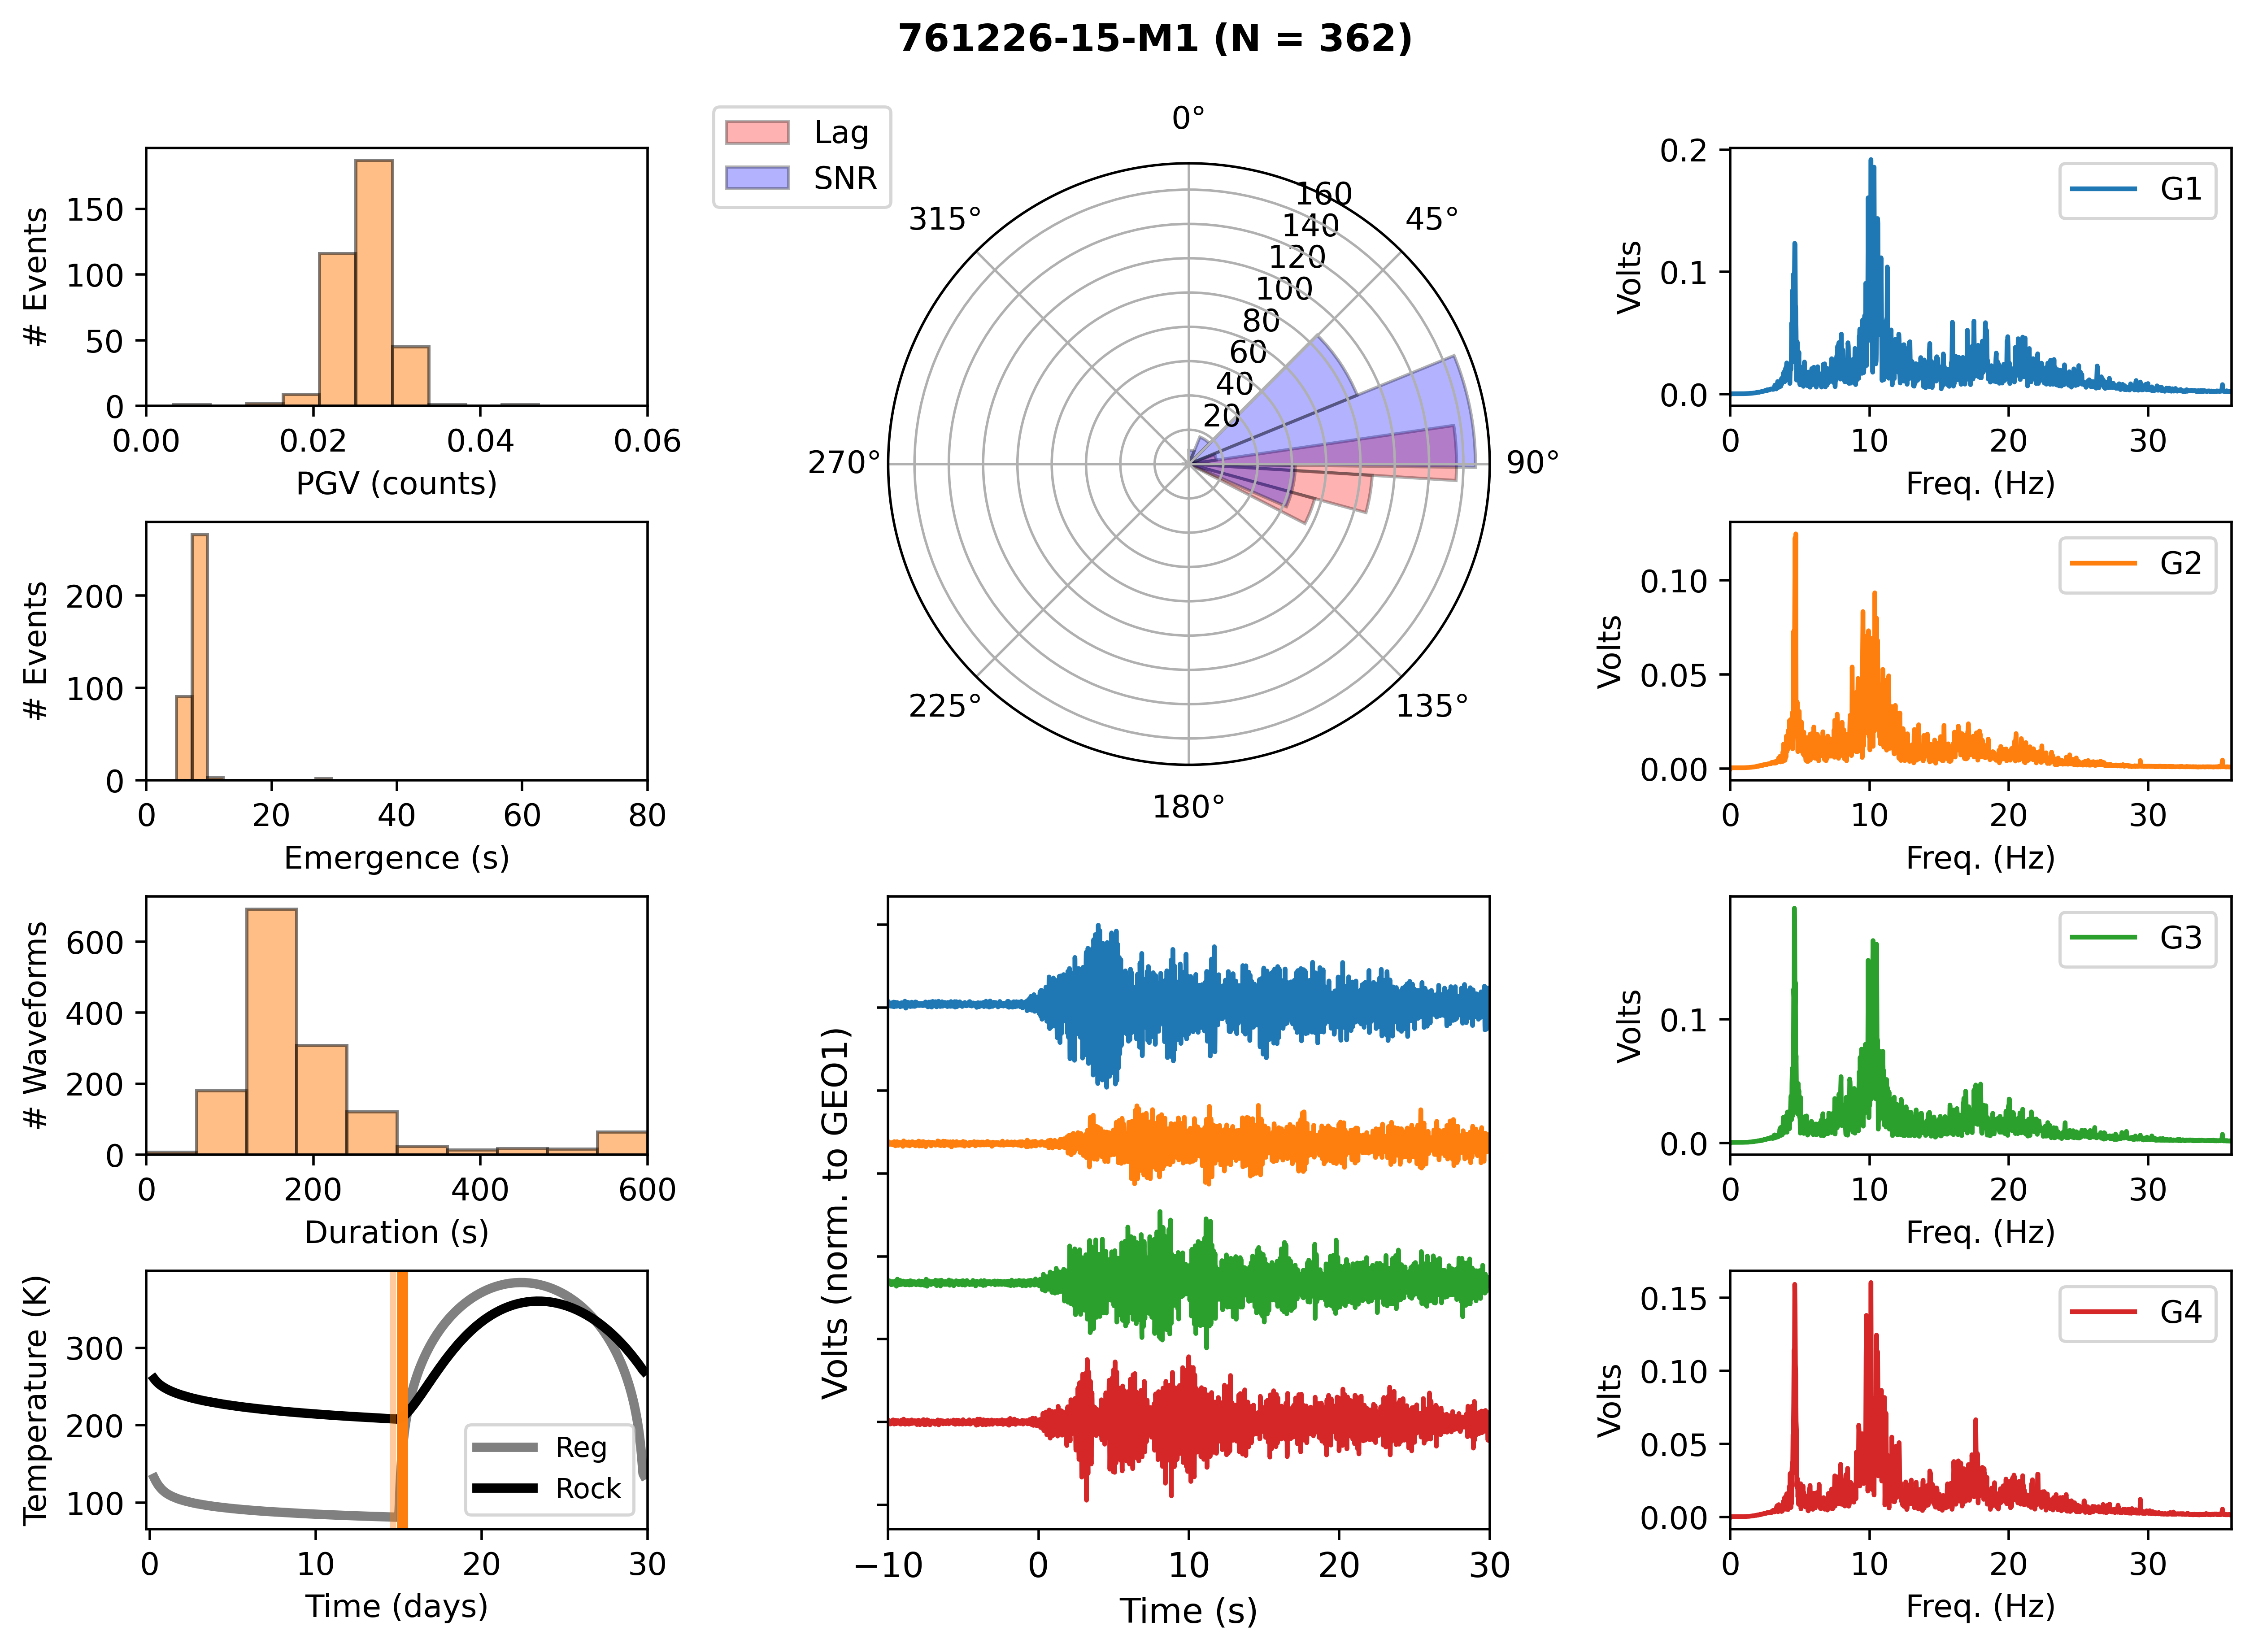

In [10]:
# Initialize figure
fig = plt.figure(figsize=(12., 8.),dpi=500)
gs = gridspec.GridSpec(4, 3, height_ratios=(1,1,1,1), width_ratios=(1,1.2,1)) 

# PGV
ax_pgv = fig.add_subplot(gs[0,0])
ax_pgv.hist(pgvs, alpha=0.5, color='C1', edgecolor='black')
ax_pgv.set_xlim([0,0.06])
ax_pgv.set_xlabel('PGV (counts)')
ax_pgv.set_ylabel('# Events')

# Emergence
ax_emg = fig.add_subplot(gs[1,0])
ax_emg.hist(emergences, alpha=0.5, color='C1', edgecolor='black')
ax_emg.set_xlim([0,80])
ax_emg.set_xlabel('Emergence (s)')
ax_emg.set_ylabel('# Events')

# Duration
ax_dur = fig.add_subplot(gs[2,0])
ax_dur.hist(durations, alpha=0.5, color='C1', edgecolor='black')
ax_dur.set_xlim([0,600])
ax_dur.set_xlabel('Duration (s)')
ax_dur.set_ylabel('# Waveforms')

# Temperature
ax_temp = fig.add_subplot(gs[3,0])
ax_temp.plot(times_day, reg_temps_day, color='grey',label='Reg',linewidth=3)
ax_temp.plot(times_day, rock_temps_day, color='black',label='Rock',linewidth=3)
ax_temp.legend(loc='lower right',fontsize=9)
ax_temp.set_xlim([-0.2,30])
ax_temp.tick_params(axis='both')
ax_temp.set_xlabel('Time (days)')
ax_temp.set_ylabel('Temperature (K)')
for num in int_days:
    ax_temp.axvline(x = num,color='C1',alpha=0.4,linewidth=2)

# Azimuths
ax_az = fig.add_subplot(gs[0:2, 1], projection='polar')
ax_az.bar(histbins_lag, counts_lag, width = histbins_lag[1] - histbins_lag[0], align='edge', color='red', edgecolor='black', alpha=0.3, label='Lag')
ax_az.bar(histbins_snr, counts_snr, width = histbins_snr[1] - histbins_snr[0], align='edge', color='blue', edgecolor='black', alpha=0.3, label='SNR')
ax_az.set_theta_zero_location("N")
ax_az.set_theta_direction(-1)
ax_az.legend(loc='upper right',bbox_to_anchor=(0.03,1.12))

# Waveforms
ax_wave = fig.add_subplot(gs[2:,1])
dist = 1.4
ax_wave.plot(trtimes1,trdata1_norm + 3.6*dist,color='C0',label='G1')
ax_wave.set_xlim([-1*befwin,aftwin])
ax_wave.set_xlabel('Time (s)',fontsize=11)
ax_wave.set_ylabel('Volts (norm. to GEO1)',fontsize=11)
ax_wave.tick_params(axis='both',labelsize=11)
ax_wave.set_yticklabels([])
ax_wave.plot(trtimes2,trdata2_norm + 2.4*dist,color='C1',label='G2')
ax_wave.plot(trtimes3,trdata3_norm + 1.2*dist,color='C2',label='G3')
ax_wave.plot(trtimes4,trdata4_norm,color='C3',label='G4')


# Plot frequency spectra
# Geophone 1
ax1 = fig.add_subplot(gs[0,2])
ax1.plot(freqs1,trdata1_fft_real,color='C0',label='G1')
ax1.set_xlim([0,36])
ax1.set_xlabel('Freq. (Hz)')
ax1.set_ylabel('Volts')
ax1.legend(loc='upper right')

# Geophone 2
ax2 = fig.add_subplot(gs[1,2])
ax2.plot(freqs2,trdata2_fft_real,color='C1',label='G2')
ax2.set_xlim([0,36])
ax2.set_xlabel('Freq. (Hz)')
ax2.set_ylabel('Volts')
ax2.legend(loc='upper right')

# Geophone 3
ax3 = fig.add_subplot(gs[2,2])
ax3.plot(freqs3,trdata3_fft_real,color='C2',label='G3')
ax3.set_xlim([0,36])
ax3.set_xlabel('Freq. (Hz)')
ax3.set_ylabel('Volts')
ax3.legend(loc='upper right')

# Geophone 4
ax4 = fig.add_subplot(gs[3,2])
ax4.plot(freqs4,trdata4_fft_real,color='C3',label='G4')
ax4.set_xlim([0,36])
ax4.set_xlabel('Freq. (Hz)')
ax4.set_ylabel('Volts')
ax4.legend(loc='upper right')

# Adjust
plt.subplots_adjust(hspace = 0.45)
plt.subplots_adjust(wspace = 0.45)
plt.suptitle(f'{evid_ref} (N = {num_evts})',fontweight='bold',fontsize=12,y=0.95)

### Iteratively plot for all families and save results

Note, I break apart this loop to compile the results into multiple PDF files, as opposed to one gigantic PDF...

In [20]:
savedir = '/data/ytamama/figures/Apollo17/families/stats/'
pngnames = []
numevts_largest = 0
# Split loop
#for v in np.arange(0,174):
for v in np.arange(174,len(evid_refs)):

    ### Catalog for each family
    evid_ref = evid_refs[v]
    rows1 = repeating_cat1.loc[repeating_cat1.evid_ref == evid_ref]
    rows2 = repeating_cat2.loc[repeating_cat2.evid_ref == evid_ref]
    evids_family = np.unique(rows2.evid.tolist())
    num_evts = len(evids_family)
    
    ###############################

    ### Stack waveforms
    first1 = 1
    first2 = 1
    first3 = 1
    first4 = 1
    
    # Iterate through events
    for r in np.arange(0,len(rows1)):

        # Arrival time
        row1 = rows1.iloc[r]
        geonum = row1.geophone
        evid = row1.evid
        row2 = rows2.loc[rows2.evid == evid].iloc[0]
        arrtime_avg = datetime.strptime(row2.avg_picktime_SNR, '%Y-%m-%d %H:%M:%S.%f')
        st = moon2sac(arrtime_avg,geonum,befwin,aftwin,minfreq,maxfreq,parentdir)

        # Geophone 1
        if geonum == 1:
            if (st != '') & (first1 == 1):
                evtst1 = st.copy()
                first1 = 0
            elif (st != '') & (first1 == 0):
                evtst1 += st

        # Geophone 2
        elif geonum == 2:
            if (st != '') & (first2 == 1):
                evtst2 = st.copy()
                first2 = 0
            elif (st != '') & (first2 == 0):
                evtst2 += st

        # Geophone 3
        elif geonum == 3:
            if (st != '') & (first3 == 1):
                evtst3 = st.copy()
                first3 = 0
            elif (st != '') & (first3 == 0):
                evtst3 += st

        # Geophone 4
        elif geonum == 4:
            if (st != '') & (first4 == 1):
                evtst4 = st.copy()
                first4 = 0
            elif (st != '') & (first4 == 0):
                evtst4 += st

    # Stack
    # Geophone 1
    st_stack1 = evtst1.copy()
    st_stack1.stack(npts_tol=2)
    # Geophone 2
    st_stack2 = evtst2.copy()
    st_stack2.stack(npts_tol=2)
    # Geophone 3
    st_stack3 = evtst3.copy()
    st_stack3.stack(npts_tol=2)
    # Geophone 4
    st_stack4 = evtst4.copy()
    st_stack4.stack(npts_tol=2)

    # Geophone 1
    trtimes1 = st_stack1.traces[0].times() - befwin
    trdata1 = st_stack1.traces[0].data

    # Geophone 2
    trtimes2 = st_stack2.traces[0].times() - befwin
    trdata2 = st_stack2.traces[0].data

    # Geophone 3
    trtimes3 = st_stack3.traces[0].times() - befwin
    trdata3 = st_stack3.traces[0].data

    # Geophone 4
    trtimes4 = st_stack4.traces[0].times() - befwin
    trdata4 = st_stack4.traces[0].data

    # Normalize relative to Geophone 1
    trdata1_norm = trdata1 / np.max(np.abs(trdata1))
    trdata2_norm = trdata2 / np.max(np.abs(trdata1))
    trdata3_norm = trdata3 / np.max(np.abs(trdata1))
    trdata4_norm = trdata4 / np.max(np.abs(trdata1))

    ###############################

    # Obtain waveform characteristics of family
    int_days = np.array(rows2.avg_interval_day.tolist())
    pgvs = np.array(rows2.avg_PGV.tolist())
    durations = np.array(rows1.duration_s.tolist())
    emergences = np.array(rows2.avg_emergence_s.tolist())

    # Obtain azimuths of family
    thetas_lag = np.array(rows2.theta_mean_lag_deg.tolist())
    sds_lag = np.array(rows2.theta_sd_lag_deg.tolist())
    thetas_snr = np.array(rows2.theta_mean_snr_deg.tolist())
    sds_snr = np.array(rows2.theta_sd_snr_deg.tolist())

    # Bin azimuths from lag
    theta_mean_radii_lag = (thetas_lag * np.pi) / 180
    counts_lag, histbins_lag = np.histogram(theta_mean_radii_lag)
    histbins_lag = histbins_lag[:-1]

    # Bin azimuths from SNR pick
    theta_mean_radii_snr = (thetas_snr * np.pi) / 180
    counts_snr, histbins_snr = np.histogram(theta_mean_radii_snr)
    histbins_snr = histbins_snr[:-1]
    
    ###############################
    
    ### Stack frequency spectra
    T = 1/117.6
    first1 = 1
    first2 = 1
    first3 = 1
    first4 = 1
    num1 = 0
    num2 = 0
    num3 = 0
    num4 = 0

    # Iterate through events
    for r in np.arange(0,len(rows1)):

        # Obtain trace
        row1 = rows1.iloc[r]
        arrtime = datetime.strptime(row1.picktime_SNR, '%Y-%m-%d %H:%M:%S.%f')
        geonum = row1.geophone
        st = moon2sac(arrtime,geonum,befwin,aftwin,minfreq,maxfreq,parentdir)
        trdata = st.traces[0].data

        # Normalize each FFT with respect to # samples
        N = len(trdata)
        trdata_fft_real = np.abs(fft(trdata).real[0:N//2]) / N

        # Which geophone?
        if geonum == 1:
            if first1 == 1:
                trdata1_fft_real = trdata_fft_real.copy()
                first1 = 0
                trdata1 = trdata.copy()
            else:
                trdata1_fft_real += trdata_fft_real.copy()
            num1 += 1
        elif geonum == 2:
            if first2 == 1:
                trdata2_fft_real = trdata_fft_real.copy()
                first2 = 0
                trdata2 = trdata.copy()
            else:
                trdata2_fft_real += trdata_fft_real.copy()
            num2 += 1
        elif geonum == 3:
            if first3 == 1:
                trdata3_fft_real = trdata_fft_real.copy()
                first3 = 0
                trdata3 = trdata.copy()
            else:
                trdata3_fft_real += trdata_fft_real.copy()
            num3 += 1
        elif geonum == 4: 
            if first4 == 1:
                trdata4_fft_real = trdata_fft_real.copy()
                first4 = 0
                trdata4 = trdata.copy()
            else:
                trdata4_fft_real += trdata_fft_real.copy()
            num4 += 1

    # Frequencies
    # Geophone 1
    N = len(trdata1)
    T = 1/117.6
    freqs1 = fftfreq(N, T)[:N//2]

    # Geophone 2
    N = len(trdata2)
    freqs2 = fftfreq(N, T)[:N//2]

    # Geophone 3
    N = len(trdata3)
    freqs3 = fftfreq(N, T)[:N//2]

    # Geophone 4
    N = len(trdata4)
    freqs4 = fftfreq(N, T)[:N//2]

    ###############################
    
    ### Initialize figure
    fig = plt.figure(figsize=(12., 8.))
    gs = gridspec.GridSpec(4, 3, height_ratios=(1,1,1,1), width_ratios=(1,1.2,1)) 

    ### PGV
    ax_pgv = fig.add_subplot(gs[0,0])
    ax_pgv.hist(pgvs, alpha=0.5, color='C1', edgecolor='black')
    ax_pgv.set_xlim([0,0.06])
    ax_pgv.set_xlabel('PGV (counts)')
    ax_pgv.set_ylabel('# Events')

    ### Emergence
    ax_emg = fig.add_subplot(gs[1,0])
    ax_emg.hist(emergences, alpha=0.5, color='C1', edgecolor='black')
    ax_emg.set_xlim([0,80])
    ax_emg.set_xlabel('Emergence (s)')
    ax_emg.set_ylabel('# Events')

    ### Duration
    ax_dur = fig.add_subplot(gs[2,0])
    ax_dur.hist(durations, alpha=0.5, color='C1', edgecolor='black')
    ax_dur.set_xlim([0,600])
    ax_dur.set_xlabel('Duration (s)')
    ax_dur.set_ylabel('# Waveforms')

    ### Temperature
    ax_temp = fig.add_subplot(gs[3,0])
    ax_temp.plot(times_day, reg_temps_day, color='grey',label='Reg',linewidth=3)
    ax_temp.plot(times_day, rock_temps_day, color='black',label='Rock',linewidth=3)
    ax_temp.legend(loc='lower right',fontsize=9)
    ax_temp.set_xlim([-0.2,30])
    ax_temp.tick_params(axis='both')
    ax_temp.set_xlabel('Time (days)')
    ax_temp.set_ylabel('Temperature (K)')
    for num in int_days:
        ax_temp.axvline(x = num,color='C1',alpha=0.4,linewidth=2)

    ### Azimuths
    ax_az = fig.add_subplot(gs[0:2, 1], projection='polar')
    ax_az.bar(histbins_lag, counts_lag, width = histbins_lag[1] - histbins_lag[0], align='edge', color='red', edgecolor='black', alpha=0.3, label='Lag')
    ax_az.bar(histbins_snr, counts_snr, width = histbins_snr[1] - histbins_snr[0], align='edge', color='blue', edgecolor='black', alpha=0.3, label='SNR')
    ax_az.set_theta_zero_location("N")
    ax_az.set_theta_direction(-1)
    ax_az.legend(loc='upper right',bbox_to_anchor=(0.03,1.12))

    ### Waveforms
    ax_wave = fig.add_subplot(gs[2:,1])
    dist = 1.4
    ax_wave.plot(trtimes1,trdata1_norm + 3.6*dist,color='C0',label='G1')
    ax_wave.set_xlim([-1*befwin,aftwin])
    ax_wave.set_xlabel('Time (s)',fontsize=11)
    ax_wave.set_ylabel('Volts (norm. to GEO1)',fontsize=11)
    ax_wave.tick_params(axis='both',labelsize=11)
    ax_wave.set_yticklabels([])
    ax_wave.plot(trtimes2,trdata2_norm + 2.4*dist,color='C1',label='G2')
    ax_wave.plot(trtimes3,trdata3_norm + 1.2*dist,color='C2',label='G3')
    ax_wave.plot(trtimes4,trdata4_norm,color='C3',label='G4')

    ### Plot frequency spectra
    # Geophone 1
    ax1 = fig.add_subplot(gs[0,2])
    ax1.plot(freqs1,trdata1_fft_real,color='C0',label='G1')
    ax1.set_xlim([0,36])
    ax1.set_xlabel('Freq. (Hz)')
    ax1.set_ylabel('Volts')
    ax1.legend(loc='upper right')

    # Geophone 2
    ax2 = fig.add_subplot(gs[1,2])
    ax2.plot(freqs2,trdata2_fft_real,color='C1',label='G2')
    ax2.set_xlim([0,36])
    ax2.set_xlabel('Freq. (Hz)')
    ax2.set_ylabel('Volts')
    ax2.legend(loc='upper right')

    # Geophone 3
    ax3 = fig.add_subplot(gs[2,2])
    ax3.plot(freqs3,trdata3_fft_real,color='C2',label='G3')
    ax3.set_xlim([0,36])
    ax3.set_xlabel('Freq. (Hz)')
    ax3.set_ylabel('Volts')
    ax3.legend(loc='upper right')

    # Geophone 4
    ax4 = fig.add_subplot(gs[3,2])
    ax4.plot(freqs4,trdata4_fft_real,color='C3',label='G4')
    ax4.set_xlim([0,36])
    ax4.set_xlabel('Freq. (Hz)')
    ax4.set_ylabel('Volts')
    ax4.legend(loc='upper right')

    ### Adjust
    plt.subplots_adjust(hspace = 0.45)
    plt.subplots_adjust(wspace = 0.45)
    plt.suptitle(f'{evid_ref} (N = {num_evts})',fontweight='bold',fontsize=12,y=0.95)

    ### Save plot
    plt.savefig(savedir + 'EVID' + evid_ref + '_stats.png', bbox_inches='tight')
    pngnames.append(savedir + 'EVID' + evid_ref + '_stats.png')
    plt.close()

In [21]:
# Aggregate figures into PDF
images = [
    Image.open(f)
    for f in pngnames
]
#pdf_path = savedir + 'FileS1.pdf'
pdf_path = savedir + 'FileS2.pdf'
images[0].save(
    pdf_path, "PDF" ,resolution=100.0, save_all=True, append_images=images[1:]
)

In [22]:
for pngname in pngnames:
    os.system('rm ' + pngname)